# Exercise 44: Electricity storage 

In this exercise you will work an extension of the $\texttt{mBasicInt}$ model, with the extension being the inclusion of a technology with capacity for electricity storage. The analytical structure of the model is outlined in Exercise 44_H, which is available on absalon. We strongly recommend that you cover the material in Exercise 44-H, before proceeding.

We start by importing basic packages and specifying where to place figures.

In [1]:
%run ../stdPackages.ipynb
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data we are using to parameterize the model is located at

In [2]:
path_to_data = os.path.join(d['curr'],'E44','Data','E44_Data.xlsx')
print(path_to_data)

c:\Users\Peter Bendix\OneDrive\Skrivebord\EnergyEconomicsE2024\Exercises\E44\Data\E44_Data.xlsx


The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP | $\mu$ |
| LoadVariation $\times$ Load | $D_h$ |
| CapVariation | $\gamma_{i,h} $ |
| sCap | $\overline{S}_i$ |
| effS | $\sqrt{\eta_i}$ |

Note that $c$ is also an index for the consumer type in the data file. 

The following section imports the data:

In [3]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

# E1

Recall that the social planner problem in the system of equations in __(1)__ of Exercise 44-H is a linear programming problem an can be expressed on the form

\begin{align} 
    &\min_{x} \ c^T\cdot x \tag{2A}\\ 
    &l\leq x\leq u, \tag{2B} \\
    &A_{eq}\times x  = b_{eq} \tag{2C}\\ 
\end{align}
where: 
* $x$ is the vector of choice variables of length ($N$).
* $c, l, u$ are coefficient vectors of the same length ($N$).
* $b_{eq}, b_{ub}$ are coefficient vectors of lengths $N_{eq}, N_{ub}$, 
* and $A_{eq}, A_{ub}$ are coefficient matrices of sizes $(N_{eq}\times N)$ and $(N_{ub} \times N)$ respectively.


In the `py`-folder for this exercise, the modelclass we will be working with is located in `ModelClass.py`. Under the `mSimple` class (post line 91), you will fill in the missing lines of code to extend the $\texttt{mBasicInt}$ model to include energy storage. 


_c-vector:_  
__For the c-vector in (2A) fill in coefficient related to the discharge $(Y_{i,h}^d)$ and charge $(Y_{i,h}^c)$ decisions in the c-property of__ `mSimple`:
```python
    @property
    def c(self):
        return [{'varName': 'Generation',
                 'value': adjMultiIndex.bc(self.db['mc'], self.globalDomains['Generation']), 
                 'conditions': getTechs(['Standard'],self.db)},
                {'varName': 'HourlyDemand',
                 'value':-adjMultiIndex.bc(self.db['MWP'], self.globalDomains['HourlyDemand'])},
                {'varName': 'discharge',
                 'value': ...Fill in here...,
                 'conditions': getTechs('Storage',self.db)},
                {'varName': 'charge',
                 'value': ...Fill in here...,
                 'conditions': ...Fill in here...}]
```
_u-vector:_   
__For the u-vector in (2B) fill in upper bound related to the discharge $(Y_{i,h}^d)$, charge $(Y_{i,h}^c)$, and storage $(S_{i,h})$ decisions in the u-property of `mSimple`:__
```python
    @property
    def u(self):
        return [{'varName': 'Generation', 
                 'value': adjMultiIndex.bc(self.hourlyGeneratingCap, self.globalDomains['Generation']), 
                 'conditions': getTechs(['Standard'],self.db)},
                {'varName': 'HourlyDemand', 'value': self.hourlyLoad_c},
                {'varName': 'stored', 
                 'value': adjMultiIndex.bc(self.db['sCap'], self.globalDomains['stored'])},
                {'varName': 'discharge', 
                 'value': ...Fill in here...,
                 'conditions': getTechs('Storage',self.db)},
                {'varName': 'charge',
                 'value': Fill in here..., 
                 'conditions': Fill in here...}]
```

__Finally, make sure your code is correct by solving for the baseline scenario, where this is no storage__:

In [4]:
import sys
sys.path.append(os.path.join(d['curr'], 'E44', 'py'))
from ModelClass_SolutionGuide import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Save solution for later:

In [5]:
base_db = m.db.copy()

In the following, we will aggregate the fuel types to the following types:

In [6]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

___
___Answer:___

See the ModelClass_SolutionGuide.py.

## E2

Below, the average merit order curve, the average marginal inverse fuel effiency, and the average marginal $CO_2$ intensity is illustrated.

**Describe the supply curve.**

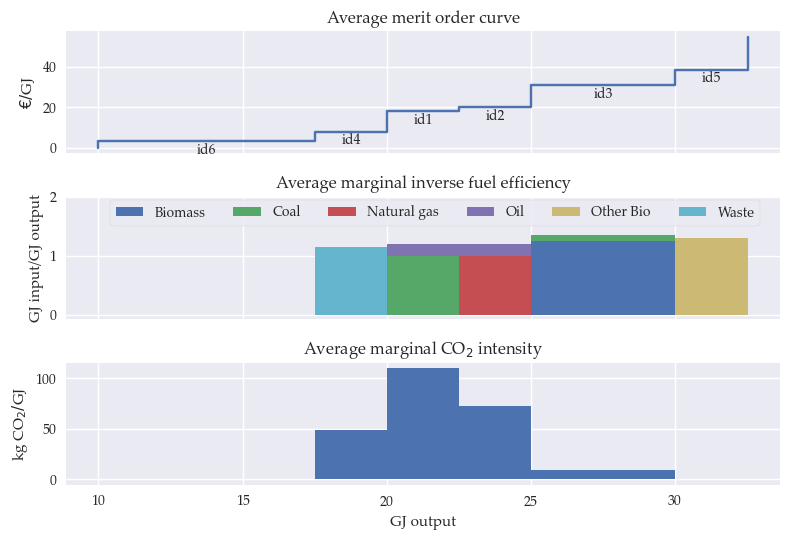

In [7]:
Image(os.path.join(figs_path,'E2.2_sol.png'))

_Note: The code for generating the figure is:_

In [8]:
%%capture
# Settings
ϵ=np.finfo(float).eps*1e10
lower_point=0
upper_point=m.db['MWP']*1.1

# Make dataframe
df_fuelineff = m.db['FuelMix'].rename(agg_BFt,level='BFt').groupby(['id','BFt']).sum().unstack('BFt').rename_axis(None,axis=1)
df = pd.concat(
    [m.hourlyGeneratingCap.groupby('id').agg('mean').rename('q').astype(float),m.db['mc'].rename('p').astype(float)]+
    [df_fuelineff]+
    [plantEmissionIntensity(m.db).xs('CO2',level='EmissionType').rename('m').mul(1000)]
    ,axis=1
).fillna(0)

# Sort and aggregate
df = df.sort_values(['p'])
df['q_cs'] = df['q'].transform('cumsum')

# Add upper points for step plotting
df_up = df.copy()
df_up['q_cs'] = df_up['q_cs']+ϵ
df_up['p'] = df_up['p'].shift(-1).fillna(upper_point)
df_up[df_fuelineff.columns.values] = df_up[df_fuelineff.columns.values].shift(-1)
df_up['m'] = df_up['m'].shift(-1)
df = pd.concat([df,df_up],axis=0).sort_values(['p','q_cs'])
df['q_diff'] = df['q_cs'].diff().div(2)
df['q_mean'] = df['q_cs']-df['q_diff']

# Now plot
fig, ax = plt.subplots(ncols=1,nrows=3,sharex=True,sharey=False)

# Merit order cuve:
df.set_index(['q_cs'])['p'].plot(ax=ax[0],ylabel=r'$€/$GJ',title='Average merit order curve')
for i in adj.rc_pd(m.db['id'],getTechs(['Standard'],m.db)):
    df_tmp = df.loc[i].copy()
    ax[0].text(x=df_tmp.iloc[0]['q_mean'],y=df_tmp.iloc[0]['p']-1,s=i,ha='center',va='top')

# Marginal fuel inefficiency
df.set_index(['q_cs'])[df_fuelineff.columns].plot(kind='area',linewidth=0,ax=ax[1],legend=False,stacked=True,ylabel='GJ input/GJ output',title='Average marginal inverse fuel efficiency')
ax[1].set_ylim(top=2)
fig.legend(handles=ax[1].get_legend_handles_labels()[0],loc='upper center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.55,0.64))

# Marginal emission coefficient
df.set_index(['q_cs'])['m'].plot(kind='area',linewidth=0,ax=ax[2],legend=False,xlabel='GJ output',ylabel=r'kg CO$_2/$GJ',title=r'Average marginal CO$_2$ intensity')

fig.tight_layout()
fig.savefig(f"{figs_path}\\E2.2_sol.png", edgecolor='k',bbox_inches='tight')

___
___Answer:___

- `id6` is a wind farm with a marginal costs of generation of 3 $€/$GJ. The installed/theoretical capacity if 25 but the average/practical generating capacity is only around 7.5.
- `id4` is a relatively cheap waste incineration plant, which is associted with CO$_2$ emissions.
- `id1` is next on the merit order curve and is predominately a coal plant. Even though it is not the most fuel inefficient generator it has by far the largest emission intensity.
- `id2` is a predominately a natural-gas fired plant and has the second highest emission intensity.
- `id3` is a biomass-fired plant associated with moderate CO$_2$ emissions since it also uses a small input of coal.
- `id5` is the last generator on the merit order curve and it is relatively costly mainly due to high fuel costs. 

## E3

**Describe the residual demand curve and the prices.**

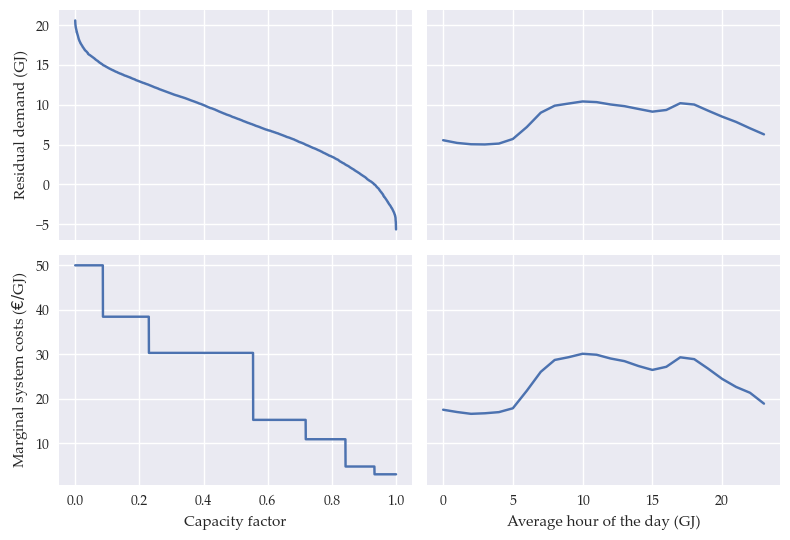

In [9]:
Image(os.path.join(figs_path,'E2.3_sol.png'))

_Note: The code for generating the figure is:_

In [10]:
%%capture
# Make dataframe
int_id = adj.rc_pd(m.db['id2hvt'], pd.Index(['Wind','Solar'], name = 'hvt')).droplevel('hvt')
df_sort =  pd.concat([
    adj.rc_pd(m.hourlyGeneratingCap,int_id).groupby('h').sum().rename('E').astype(float),
    m.hourlyLoad.rename('L').astype(float),
    m.db['marginalSystemCosts'].rename('p').astype(float)
],axis=1)

# Calculate residual demand
df_sort['resd'] = df_sort['L']-df_sort['E']

# Sort dataframe
df_sort = df_sort.sort_values(['resd'],ascending=False).reset_index()
df_sort.index = df_sort.index/len(df_sort)

# Make new dataframe with time mappings
df_h = df_sort.merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Aggregate for average hour of the day
df_h = df_h.groupby('HourOfTheDay')[['resd','p']].mean()

# Make plot
fig, ax = plt.subplots(nrows=2,ncols=2,sharey='row',sharex='col')

df_sort['resd'].plot(ax=ax[0,0],ylabel=r'Residual demand (GJ)')
df_sort['p'].plot(ax=ax[1,0],ylabel=r'Marginal system costs ($€/$GJ)',xlabel='Capacity factor')
df_h['resd'].plot(ax=ax[0,1])
df_h['p'].plot(xlabel='Average hour of the day (GJ)',ax=ax[1,1])

fig.tight_layout()
fig.savefig(f"{figs_path}\\E2.3_sol.png", edgecolor='k',bbox_inches='tight')

___
___Answer:___

In the baseline scenario - where this is no capacity for electricity storage - there is a surplus of wind electricity in around 7% of the year (upper left figure). This surplus electricity gets curtailed in equilibrium. Comparing the upper left panel with the lower left figure, we see that prices of the year closely follows the share of the residual demand curve. 

This is also illustrated in the right column of the figure, which shows the average residual demand curve (upper right) and the marginal system costs (lower right) over the hours of the day. In general, electricity is scarce around 10 and 18 and abundant during night hours. 

## E4

In the following we will run an experiment where we exogenously vary the capacity of the storage technology from 0 to 10. We will assume the storage duration of the technology is 4 hours.

We first define the two grids to solve the model over:

In [38]:
# Setting
E2P = 6 # The "energy storage to power"-ratio/storage duration
maxcap = 10
loop = pd.Index(range(11), name = 'loop')
v0_ECap = pd.Series(0.001, index = getTechs(['Storage'],m.db))
vT_ECap = pd.Series(maxcap, index = v0_ECap.index)
v0_SCap = v0_ECap.mul(E2P)
vT_SCap = vT_ECap.mul(E2P)

grid_ECap = adjMultiIndex.addGrid(v0_ECap,vT_ECap,loop,'GeneratingCapacity').astype(int)
grid_SCap = adjMultiIndex.addGrid(v0_SCap,vT_SCap,loop,'sCap').astype(int)

Kopi af koden ovenfor men med efficiency changes

In [37]:
# Define efficiency levels and capacity loop
efficiency_levels = [0.90, 0.95, 0.99]  # Efficiency levels to iterate
E2P = 6  # Energy-to-power ratio
maxcap = 10
loop = pd.Index(range(11), name='loop')  # 11 steps in capacity loop

# Initial and terminal energy capacities
v0_ECap = pd.Series(0.001, index=getTechs(['Storage'], m.db))  # Initial capacity
vT_ECap = pd.Series(maxcap, index=v0_ECap.index)  # Terminal capacity
v0_SCap = v0_ECap.mul(E2P)  # Initial power capacity
vT_SCap = vT_ECap.mul(E2P)  # Terminal power capacity

# Iterate over both storage capacity and efficiency
results = []  # To store results
for efficiency in efficiency_levels:
    for step in loop:
        # Interpolate capacity for the current loop step
        current_ECap = v0_ECap + (vT_ECap - v0_ECap) * step / loop.max()
        current_SCap = v0_SCap + (vT_SCap - v0_SCap) * step / loop.max()
        
        # Update efficiency and storage capacities in the model
        m.db['effS'] = efficiency
        m.db['GeneratingCapacity'] = current_ECap
        m.db['sCap'] = current_SCap

        # Solve the model
        m.preSolve(recomputeMC=True)
        solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], ['Emissions', 'consumerSurplus', 'producerSurplus'])

        # Extract results
        emissions = solution['Emissions'].sum()
        consumer_surplus = solution['consumerSurplus'].sum()
        producer_surplus = solution['producerSurplus'].sum()
        welfare = consumer_surplus + producer_surplus

        # Store results
        results.append({
            'Efficiency': efficiency,
            'Step': step,
            'EnergyCapacity': current_ECap.sum(),
            'PowerCapacity': current_SCap.sum(),
            'Emissions': emissions,
            'Welfare': welfare
        })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Analyze results
print(results_df)


KeyboardInterrupt: 

In [12]:
m.db['GeneratingCapacity']  # Check if the numbers are in MW or GW.
m.db['Load']  # Inspect the load data to determine scale.
m.db['Load']
m.db['EmissionIntensity']

BFt          EmissionType
Coal         CO2             0.09437
Fueloil      CO2             0.07919
Gasoil       CO2              0.0741
NatGas       CO2               0.057
Straw        CO2                   0
WoodPellets  CO2                   0
WoodChips    CO2                   0
WoodWaste    CO2                   0
Waste        CO2              0.0425
Biogas       CO2                   0
BioOil       CO2                   0
Name: EmissionIntensity, dtype: object

In [13]:
print(m.db['EmissionTax'])



EmissionType
CO2    35.513339
Name: EmissionTax, dtype: object


We will also be extracting the following variables:

In [14]:
extract = ['marginalSystemCosts','Generation','charge','discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','hourlyEmissions','Emissions','consumerSurplus','producerSurplus','Welfare']

In [15]:
# Extract specified metrics from the model database
results = {key: m.db[key] for key in extract}

# Example: Accessing and analyzing emissions
total_emissions = results['Emissions']
hourly_emissions = results['hourlyEmissions']


In [35]:
# Print all fuel prices from the model database
print("Fuel Prices:")
print(m.db['FuelPrice'])


Fuel Prices:
BFt
Coal            2.362462
Fueloil         5.812119
Gasoil         10.465381
NatGas          5.046242
Straw           5.869473
WoodPellets     9.467111
WoodChips       6.996357
WoodWaste              0
Waste           0.013423
Biogas         16.040963
BioOil          7.849036
Name: FuelPrice, dtype: object


We now run the counterfactual scenarios:

In [28]:
m.db['effS'] = 0.90
m.db['GeneratingCapacity'].loc['idES'] = 5

In [36]:
print(m.db['effS'])
print(m.db['GeneratingCapacity'])

id
idES    0.9
Name: effS, dtype: float64
id
id1     2.5
id2     2.5
id3       5
id4     2.5
id5     2.5
id6      25
idES     10
Name: GeneratingCapacity, dtype: object


In [30]:
solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], extract)

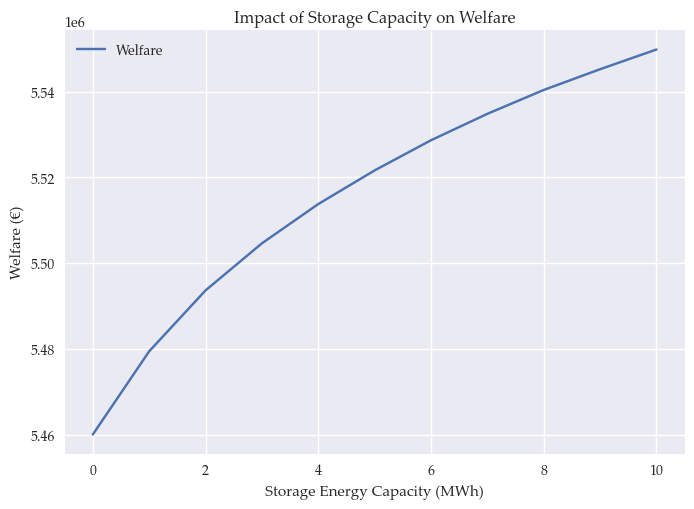

In [31]:
import matplotlib.pyplot as plt

# Plot welfare against the loop index which represents storage energy capacity
plt.plot(loop, solution['Welfare'], label='Welfare')
plt.xlabel('Storage Energy Capacity (MWh)')
plt.ylabel('Welfare (€)')
plt.title('Impact of Storage Capacity on Welfare')
plt.legend()
plt.show()


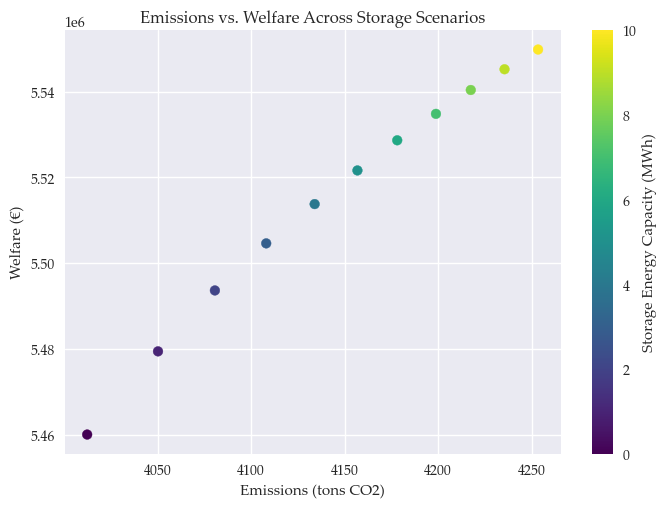

In [32]:
plt.scatter(solution['Emissions'], solution['Welfare'], c=grid_ECap, cmap='viridis')
plt.xlabel('Emissions (tons CO2)')
plt.ylabel('Welfare (€)')
plt.colorbar(label='Storage Energy Capacity (MWh)')
plt.title('Emissions vs. Welfare Across Storage Scenarios')
plt.show()


__Explain what is happening to the marginal systems costs on an average day illustrate in the figure below.__

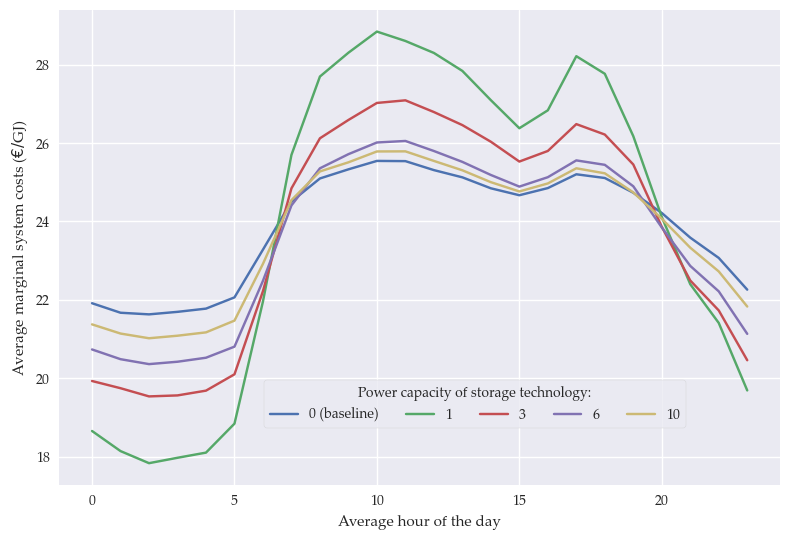

In [33]:
Image(os.path.join(figs_path,'E2.4_sol.png'))

_Note: The code for generating the figure is:_

In [21]:
%%capture
loop_id=loop[[1,3,6,10]]
# Make dataframe
df_p =  pd.concat([
    base_db['marginalSystemCosts'].rename('base').astype(float),
    adj.rc_pd(solution['marginalSystemCosts'],loop_id).unstack('loop').rename_axis(None,axis=1).astype(float)
],axis=1)

# Make new dataframe with time mappings
p_names = df_p.columns.copy()
df = df_p.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Average hour of the day',ylabel=r'Average marginal system costs ($€/$GJ)',ax=ax,legend=False)
fig.legend(['0 (baseline)']+grid_ECap[loop_id].tolist(),loc='lower center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.6,0.2),title=r'Power capacity of storage technology:')
fig.tight_layout()
fig.savefig(f"{figs_path}\\E2.4_sol.png", edgecolor='k',bbox_inches='tight')

___
___Answer:___

Wee see that prices are generally increasing in low-price hours and decreasing in high-price hours. This is because the storage technology is charging in low-price states (demand increase pushing up prices) and dispatching in high-price states (supply increase pushing down prices). This can be illustrated by the graph below: 

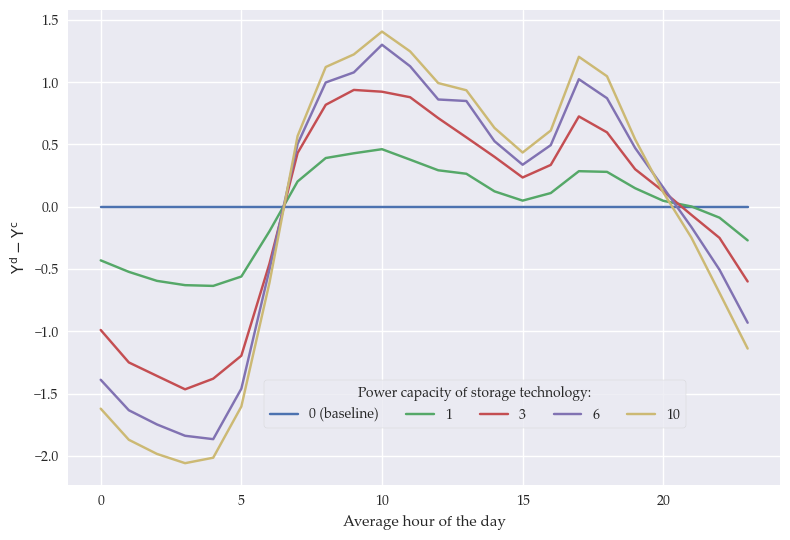

In [22]:
# Make dataframe
charge = adj.rc_pd(-solution['charge'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)
discharge = adj.rc_pd(solution['discharge'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)

df_Y =  pd.concat([charge,discharge],axis=0).groupby('h').agg('sum')
df_Y['base'] = 0

# Make new dataframe with time mappings
df = df_Y.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Average hour of the day',ylabel=r'$Y^d-Y^c$',ax=ax,legend=False)
fig.legend(['0 (baseline)']+grid_ECap[loop_id].tolist(),loc='lower center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.6,0.2),title=r'Power capacity of storage technology:')
fig.tight_layout()

## E5

The cunk of code in the following illustrates the marginal economic value of both power capacity (left) and energy capacity (right) of storage using eq. __(4)__ and __(5)__, respectively, in Exercises 44-H.

__Explain why the marginal value of power capacity goes to zero and the marginal value of energy storage is still positive (although also decreasing)__.

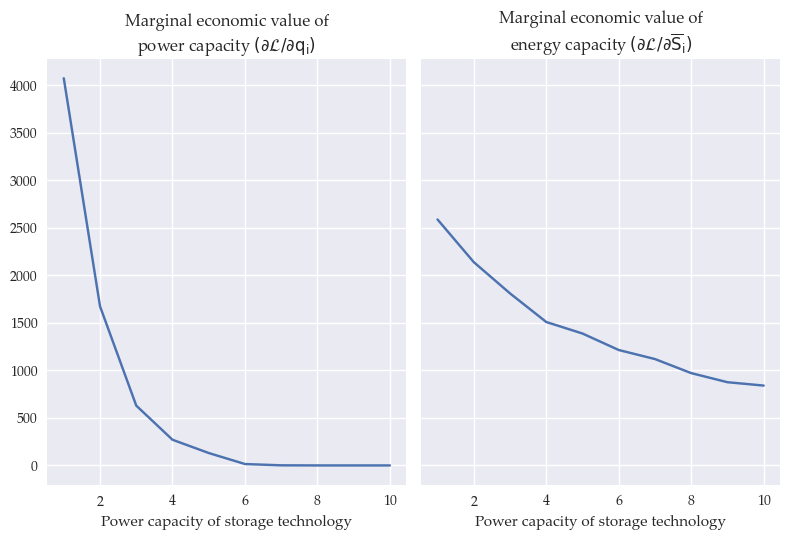

In [23]:
fig, ax = plt.subplots(ncols=2,sharey=True)
solution['marginalEconomicValue'].xs('idES',level='id').xs('Power',level='CapacityType').iloc[1:].plot(ax=ax[0],title='Marginal economic value of\npower capacity $(\partial \mathcal{L} /\partial q_{i})$',xlabel=r'Power capacity of storage technology')
solution['marginalEconomicValue'].xs('idES',level='id').xs('Energy',level='CapacityType').iloc[1:].plot(ax=ax[1],title='Marginal economic value of\nenergy capacity $(\partial \mathcal{L} /\partial \overline{S}_{i})$',xlabel=r'Power capacity of storage technology')
fig.tight_layout()

___
___Answer:___

The marginal economic value of power capacity is decreasing due to the indirect/equilibrium effect identified in eq. __(8)__ in the lecture note on electricity storage: Because the storage technology is eroding oppertunities of price arbitrage, marginally more price arbitration simply lowers the arbitrage opportunity. While this is an equilibrium effect a more conventional interpretation is that the storage technology features diminishing returns to power capacity. This effect implies that there are no short-run profits associated with investing in more power capacity above 5 GJ. 

However, we do see that the marginal value of energy storage is still positive. The intuition is that it would be optimal to invest in a storage technology with a longer storage duration than 4 hours. In other words, when the power capacity is at 5 GJ all arbitrage oppertunities within a typical day are eroded, and we would need a technology for long-term storage to take advantage of other price spreads. 

## E6

**Explain why total $CO_2$ emissions are increasing as illustrated by the folloing chunk of code:**

<Axes: xlabel='Power capacity of storage', ylabel='Ton CO$_2$'>

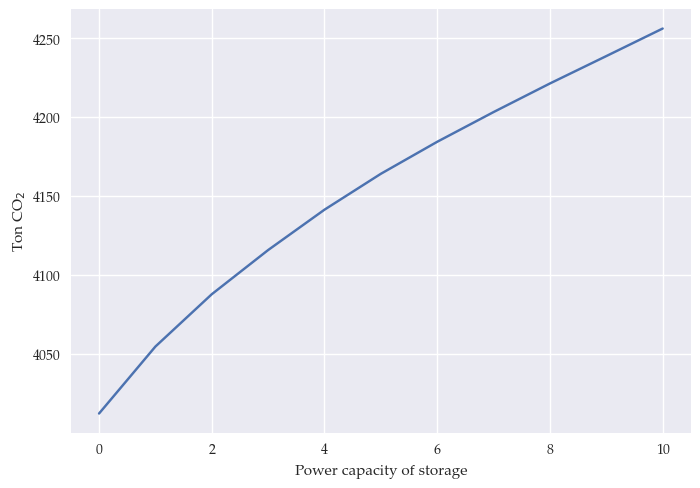

In [24]:
solution['Emissions'].plot(ylabel='Ton CO$_2$',xlabel='Power capacity of storage')

___
___Answer:___

To answer this question, we need to look at what happens to emission in low-price states vs. high-price states:

<Axes: xlabel='Hour of the day', ylabel='kg CO$_2$'>

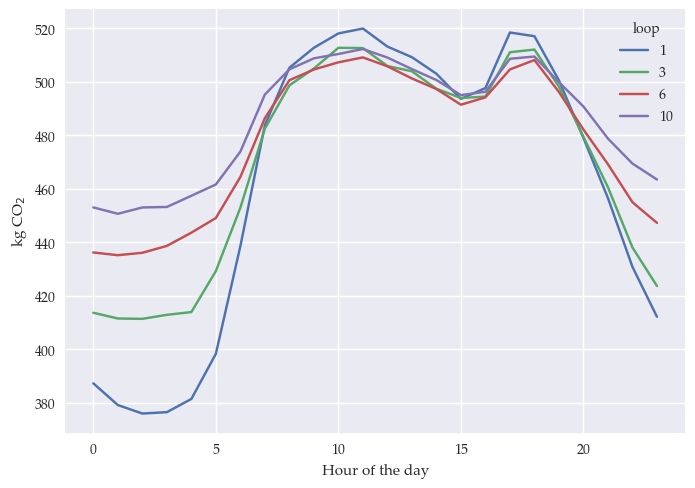

In [25]:
x = solution['hourlyEmissions'].xs('CO2',level='EmissionType').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))
adj.rc_pd(x.groupby(['HourOfTheDay','loop'])[0].mean(),loop_id).mul(1000).unstack('loop').plot(ylabel='kg CO$_2$',xlabel='Hour of the day')

While we lowering emissions in high-price states in which stored electricity is dispatch in replacing fossil-based generation, we are crowding in emission in low-price states. Specifically, we are crowding in the coal- and natural-gas fired generators, which increases emissions on net due to their high emission intensity.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to extract welfare metrics and plot
def plot_welfare_analysis(model):
    """
    Plots consumer surplus, producer surplus, and total welfare from the model outputs.

    Args:
        model: The solved model object containing welfare data in its database.
    """
    # Extract welfare metrics
    consumer_surplus = model.db['consumerSurplus'].sum()  # Sum over all hours and regions
    producer_surplus = model.db['producerSurplus'].sum()
    total_welfare = consumer_surplus + producer_surplus

    # Create a DataFrame for plotting
    welfare_data = pd.DataFrame({
        'Metric': ['Consumer Surplus', 'Producer Surplus', 'Total Welfare'],
        'Value': [consumer_surplus, producer_surplus, total_welfare]
    })

    # Plot the welfare metrics
    plt.figure(figsize=(8, 6))
    plt.bar(welfare_data['Metric'], welfare_data['Value'], color=['skyblue', 'orange', 'green'])
    plt.title('Welfare Analysis', fontsize=16)
    plt.ylabel('Value (€)', fontsize=12)
    plt.xlabel('Metric', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels on the bars
    for index, row in welfare_data.iterrows():
        plt.text(index, row['Value'] + 0.05 * row['Value'], f"{row['Value']:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming `model` is your solved model object
# Uncomment the following line to plot welfare analysis
# plot_welfare_analysis(model)


In [ ]:
#run plot_welfare_analysis(m)
plot_welfare_analysis(m)


In [ ]:
def plot_welfare_development(solutions, storage_limits):
    """
    Plots the development of welfare metrics (consumer surplus, producer surplus, total welfare)
    as storage limits change.

    Args:
        solutions: A list of model solutions (one for each storage limit scenario).
        storage_limits: A list of storage capacity values corresponding to the scenarios.
    """
    # Initialize lists to store metrics
    consumer_surpluses = []
    producer_surpluses = []
    total_welfares = []

    # Extract welfare metrics for each solution
    for solution in solutions:
        consumer_surplus = solution['consumerSurplus'].sum()
        producer_surplus = solution['producerSurplus'].sum()
        total_welfare = consumer_surplus + producer_surplus

        consumer_surpluses.append(consumer_surplus)
        producer_surpluses.append(producer_surplus)
        total_welfares.append(total_welfare)

    # Create a DataFrame for plotting
    welfare_data = pd.DataFrame({
        'Storage Capacity': storage_limits,
        'Consumer Surplus': consumer_surpluses,
        'Producer Surplus': producer_surpluses,
        'Total Welfare': total_welfares
    })

    # Plot the welfare metrics
    plt.figure(figsize=(10, 6))
    plt.plot(welfare_data['Storage Capacity'], welfare_data['Consumer Surplus'], label='Consumer Surplus', marker='o')
    plt.plot(welfare_data['Storage Capacity'], welfare_data['Producer Surplus'], label='Producer Surplus', marker='o')
    plt.plot(welfare_data['Storage Capacity'], welfare_data['Total Welfare'], label='Total Welfare', marker='o', linestyle='--')

    # Add labels, title, and legend
    plt.title('Welfare Development with Changing Storage Limits', fontsize=16)
    plt.xlabel('Storage Capacity (MWh)', fontsize=12)
    plt.ylabel('Welfare (€)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
#storage_limits = [0.1, 1, 2, 5, 10]  # Example storage capacities in MWh
#solutions = []  # List to hold solutions

#for limit in storage_limits:
    # Update storage capacity in the model
    #vT_ECap = pd.Series(limit, index=getTechs(['Storage'], m.db))
    #grid_ECap = adjMultiIndex.addGrid(v0_ECap, vT_ECap, loop, 'GeneratingCapacity').astype(int)
    #grid_SCap = adjMultiIndex.addGrid(v0_SCap, vT_SCap, loop, 'sCap').astype(int)
    
    # Solve the model and store the result
    #solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], extract)
    #solutions.append(solution)


In [ ]:
# plot_welfare_development(solutions, storage_limits)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the capacity and efficiency levels
capacity_levels = [0, 5, 10]  # MWh
efficiency_levels = [0.90, 0.95, 0.99]  # Efficiency (%)

# Create an empty list to store results
results = []

# Loop through capacity and efficiency levels
for capacity in capacity_levels:
    for efficiency in efficiency_levels:
        # Update the storage capacity and efficiency in the database
        m.db['GeneratingCapacity'].loc[getTechs(['Storage'], m.db)] = capacity
        m.db['effS'] = efficiency

        # Recompute marginal costs and solve the model
        m.preSolve(recomputeMC=True)
        solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], ['Emissions', 'consumerSurplus', 'producerSurplus'])

        # Extract results
        emissions = solution['Emissions'].sum()
        consumer_surplus = solution['consumerSurplus'].sum()
        producer_surplus = solution['producerSurplus'].sum()
        welfare = consumer_surplus + producer_surplus

        # Store the results
        results.append({
            'Capacity': capacity,
            'Efficiency': efficiency,
            'Emissions': emissions,
            'Welfare': welfare
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot Welfare vs. Efficiency for each Capacity Level
plt.figure(figsize=(10, 6))
for capacity in capacity_levels:
    subset = results_df[results_df['Capacity'] == capacity]
    plt.plot(subset['Efficiency'], subset['Welfare'], marker='o', label=f'Capacity: {capacity} MWh')

plt.xlabel('Efficiency (%)')
plt.ylabel('Welfare (€)')
plt.title('Welfare vs. Efficiency at Different Storage Capacities')
plt.legend()
plt.grid(True)
plt.show()

# Plot Emissions vs. Efficiency for each Capacity Level
plt.figure(figsize=(10, 6))
for capacity in capacity_levels:
    subset = results_df[results_df['Capacity'] == capacity]
    plt.plot(subset['Efficiency'], subset['Emissions'], marker='o', label=f'Capacity: {capacity} MWh')

plt.xlabel('Efficiency (%)')
plt.ylabel('Emissions (tons CO2)')
plt.title('Emissions vs. Efficiency at Different Storage Capacities')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(db.__dict__)  # Show all attributes in the database
print(db['FuelPrice'])  # Inspect specific parameters


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the emission tax levels to test
emission_tax_levels = [0, 20, 40, 60, 80, 100]

# Create an empty list to store results
results = []

# Loop over emission tax levels
for tax in emission_tax_levels:
    # Set the emission tax in the model
    m.db['EmissionTax'] = tax
    
    # Recalculate marginal costs to reflect updated emission taxes
    m.preSolve(recomputeMC=True)
    
    # Solve the model
    solution = m.loopSolveExtract(loop, [grid_ECap, grid_SCap], ['Emissions', 'Welfare', 'marginalEconomicValue'])
    
    # Extract the desired metrics
    total_emissions = solution['Emissions'].sum()
    total_welfare = solution['Welfare'].sum()
    marginal_values = solution['marginalEconomicValue']
    
    # Store the results as a dictionary
    results.append({
        'Tax': tax,
        'Emissions': total_emissions,
        'Welfare': total_welfare,
        'MarginalValue': marginal_values.mean()  # Example: average marginal economic value
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Plot the results
fig, ax1 = plt.subplots()

# Plot emissions
ax1.set_xlabel('Emission Tax (€)')
ax1.set_ylabel('Emissions (tons CO2)', color='blue')
ax1.plot(results_df['Tax'], results_df['Emissions'], marker='o', color='blue', label='Emissions')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis for welfare
ax2 = ax1.twinx()
ax2.set_ylabel('Welfare (€)', color='green')
ax2.plot(results_df['Tax'], results_df['Welfare'], marker='o', color='green', label='Welfare')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Impact of Emission Tax on Emissions and Welfare')
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()

# Plot marginal economic value separately
plt.figure(figsize=(8, 6))
plt.plot(results_df['Tax'], results_df['MarginalValue'], marker='o', color='orange')
plt.xlabel('Emission Tax (€)')
plt.ylabel('Average Marginal Economic Value (€)')
plt.title('Impact of Emission Tax on Marginal Economic Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

